#  Object Detection with YOLO

*HFT Stuttgart, 2025 Summer Term, Michael Mommert (michael.mommert@hft-stuttgart.de)*

Object Detection is able to classify instances of objects in an image and to approximately locate these instances. In this Notebook, we use the YOLO model to perform object detection on cars from aerial imagery of the city of Stuttgart. For a streamlined implementation, we use the [ultralytics YOLO framework](https://docs.ultralytics.com/) and fine-tune a pretrained model on our dataset. If you want some more resources on using this framework for training on a custom dataset, you can start [here](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/).

In [1]:
%pip install numpy \
    matplotlib \
    pandas \
    scikit-image \
    ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Dataset handling

We will use the "Cars in Stuttgart" dataset in this Notebook. Let's download and unpack the dataset.

In [3]:
# download dataset
!curl -O https://zenodo.org/records/15019408/files/cars_in_stuttgart.zip

# extract dataset zipfile
with zipfile.ZipFile('cars_in_stuttgart.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# rename dataset directory
os.rename('cars_in_stuttgart/', 'data/')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46.3M  100 46.3M    0     0  9350k      0  0:00:05  0:00:05 --:--:-- 10.9M


Let's read in the training image filenames and display one example image:

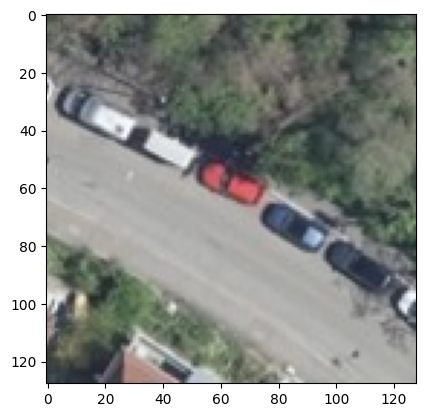

In [4]:
train_filenames = []
for f in sorted(os.listdir('data/train')):
    if f.endswith('.png'):  # consider only files ending in .png
        train_filenames.append(os.path.join('data/train', f))

img = io.imread(train_filenames[2])
plt.imshow(img)

For each image file, there is a corresonding label file. For this specific the label file looks like this:

In [5]:
with open(train_filenames[42].replace('.png', '.txt'), 'r') as f:
    for line in f.readlines():
        print(line, end='')

This file uses the YOLO convention to identify **bounding boxes**. Each line corresponds to a different bounding box and the columns have the following meanings:

1. Class label: In this case, there's only a single class, so all bounding boxes use label 0. If there were different classes, there would be different ids.
2. X center of the bounding box
3. Y center of the bounding box
4. Width of the bounding box
5. Height of the bounding box

Parameter 2-5 are given in normalized pixel coordinates, not pixels. For instance, a coordinate 0.8 corresponds to pixel 80 in a 100 pixel image or pixel 40 in a 50 pixel image.

Let's read in the bounding box information and plot the boxes on the image. Feel free to check out other image indices as well.

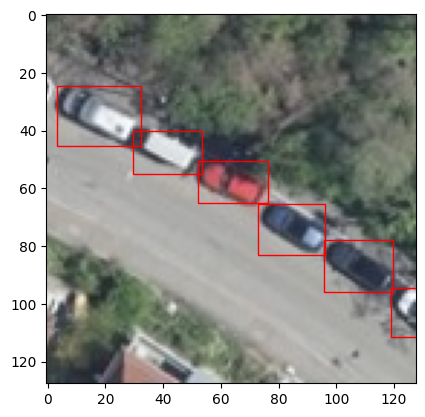

In [6]:
i = 2 # image index

# read in bounding boxes
bbs = pd.read_csv(train_filenames[i].replace('.png', '.txt'), sep=' ',
                  header=None, names=['class', 'x', 'y', 'w', 'h'])

# plot image
img = io.imread(train_filenames[i])
f, ax = plt.subplots(1, 1)
ax.imshow(img)

# add bounding boxes
h, w, c = img.shape
for i, bb in bbs.iterrows():
    # draw a rectangle for each bounding box; rectangle expects top left corner coordinates, width and heigth
    ax.add_patch(Rectangle(((bb.x-bb.w/2)*w, (bb.y-bb.h/2)*h),
                           bb.w*w, bb.h*h,
                 edgecolor='red', facecolor='none'))

## Training Process

The training process is extremely convenient using the YOLO framework. To setup the training process, we have to create a **dataset configuration file** that contains information on the following things:
* the path to the dataset root directory
* the names of the different dataset splits (those should be directories under the root path)
* the class labels (remember that we only have a single class in this example)

We write this file using some cell magic:

In [37]:
%%writefile dataset.yaml

# Train/val/test sets
path: /content/data # dataset root dir (note that this path is optimized for use in colab)
train: train # train images (relative to 'path')
val: val # val images (relative to 'path')

# define classes
names:
    0: car

Overwriting dataset.yaml


Now we have to **choose an appropriate model**. The YOLO architecture comes in different [sizes](https://github.com/ultralytics/ultralytics). The term size relates here to the number of learnable parameters that this model has. Typically, the more parameters, the more powerful the fully trained model.

We will use the smallest available model, `yolo11n`, with 2.6 million parameters and load a pretrained version of this model.

In [8]:
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 121MB/s]


Now we can stat the actual **model training or fine-tuning process**. Naturally, this process is complex and comes with a lot of parameters that can be set. We will set some of these parameters below and use the default parameters for the rest of them. For a full discussion of all available parameters, please visit the [ultralytics YOLO documentation](https://docs.ultralytics.com/usage/cfg/).

In [9]:
results = model.train(data='dataset.yaml', # define the dataset configuration file
                      task='detect', # set the task as object detection
                      epochs=15, # set the number of training epochs
                      seed=42, # set a fixed seed value for reproducibility
                      imgsz=128, # provide the size of the images
                      batch=16, # batch size 16 images
                      optimizer='Adam', # use the Adam optimizer
                      lr0=0.001, # learning rate at epoch 0
                      plots=True, # plot analytics during training
                      )

Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=dataset.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

100%|██████████| 755k/755k [00:00<00:00, 19.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/data/train... 1000 images, 377 backgrounds, 13 corrupt: 100%|██████████| 1000/1000 [00:00<00:00, 2462.83it/s]

train: WARNING ⚠️ /content/data/train/511600_5401780_Base_A62_Luftbild_2021_EPSG25832.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2216]
train: WARNING ⚠️ /content/data/train/511600_5402778_Base_A62_Luftbild_2021_EPSG25832.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3653]
train: WARNING ⚠️ /content/data/train/511600_5403045_Base_A62_Luftbild_2021_EPSG25832.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0988]
train: WARNING ⚠️ /content/data/train/511600_5403142_Base_A62_Luftbild_2021_EPSG25832.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2407      1.0336      1.1791      1.2305      1.1257]
train: WARNING ⚠️ /content/data/train/511600_5403337_Base_A62_Luftbild_2021_EPSG25832.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1119      1.2455]
train: WARNING ⚠️ /content/data/train/511600_

train: New cache created: /content/data/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/val... 190 images, 37 backgrounds, 3 corrupt: 100%|██████████| 190/190 [00:00<00:00, 1737.35it/s]

val: WARNING ⚠️ /content/data/val/513107_5401318_Base_A62_Luftbild_2021_EPSG25832.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/data/val/513107_5401416_Base_A62_Luftbild_2021_EPSG25832.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/data/val/513107_5401464_Base_A62_Luftbild_2021_EPSG25832.png: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: New cache created: /content/data/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15     0.254G       2.44      2.238      1.194         29        128: 100%|██████████| 62/62 [00:10<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


                   all        187        411    0.00542      0.693      0.257     0.0921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      0.27G      2.113      1.499      1.087         23        128: 100%|██████████| 62/62 [00:07<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]

                   all        187        411      0.673      0.635      0.614      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15     0.285G      2.069      1.371       1.08         15        128: 100%|██████████| 62/62 [00:09<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.77it/s]

                   all        187        411      0.635      0.623      0.592      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15     0.299G       1.98      1.287       1.06         14        128: 100%|██████████| 62/62 [00:07<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.63it/s]

                   all        187        411      0.559      0.558      0.516      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15     0.314G      1.955      1.239      1.045         20        128: 100%|██████████| 62/62 [00:07<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.62it/s]

                   all        187        411      0.681      0.671      0.646      0.291


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15     0.328G      1.848      1.208       1.06         25        128: 100%|██████████| 62/62 [00:07<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.66it/s]

                   all        187        411      0.705      0.737       0.71      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15     0.344G      1.809        1.2      1.054          8        128: 100%|██████████| 62/62 [00:07<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.91it/s]

                   all        187        411      0.659      0.689      0.658      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15     0.357G      1.764      1.164      1.042         27        128: 100%|██████████| 62/62 [00:06<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.37it/s]

                   all        187        411      0.716      0.713      0.704      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15     0.373G      1.781      1.125      1.042         22        128: 100%|██████████| 62/62 [00:07<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.79it/s]

                   all        187        411      0.724      0.703      0.689      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15     0.387G      1.701      1.085      1.025         11        128: 100%|██████████| 62/62 [00:07<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.14it/s]

                   all        187        411      0.703      0.759      0.718       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15       0.4G      1.707      1.112      1.026         16        128: 100%|██████████| 62/62 [00:07<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.76it/s]

                   all        187        411      0.716      0.701      0.708      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15     0.416G      1.684      1.094      1.021         30        128: 100%|██████████| 62/62 [00:07<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.69it/s]

                   all        187        411       0.76       0.72      0.733       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15     0.432G      1.688      1.074      1.015         17        128: 100%|██████████| 62/62 [00:09<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.89it/s]

                   all        187        411      0.706      0.723      0.697      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15     0.445G      1.664      1.063     0.9972         18        128: 100%|██████████| 62/62 [00:14<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all        187        411        0.7      0.762      0.706      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15     0.461G      1.637       1.02      1.001         12        128: 100%|██████████| 62/62 [00:07<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.00it/s]

                   all        187        411      0.704      0.735       0.71      0.332



15 epochs completed in 0.043 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


                   all        187        411      0.759       0.72      0.733       0.34
Speed: 0.0ms preprocess, 1.0ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train


The training process generates a lot of output, which includes all the parameters and seetings (including the default ones we did not touch), data disgnostics (e.g., corrupt bounding boxes) and, of course, information on the training progress.

In addition, YOLO creates a lot of files in a new directory called `runs/`. Here you can find diagnostic plots and logfiles, example predictions and the trained model checkpoints.

You will also find a plot named `results.png` that summarizes the training progress:

(np.float64(-0.5), np.float64(2399.5), np.float64(1199.5), np.float64(-0.5))

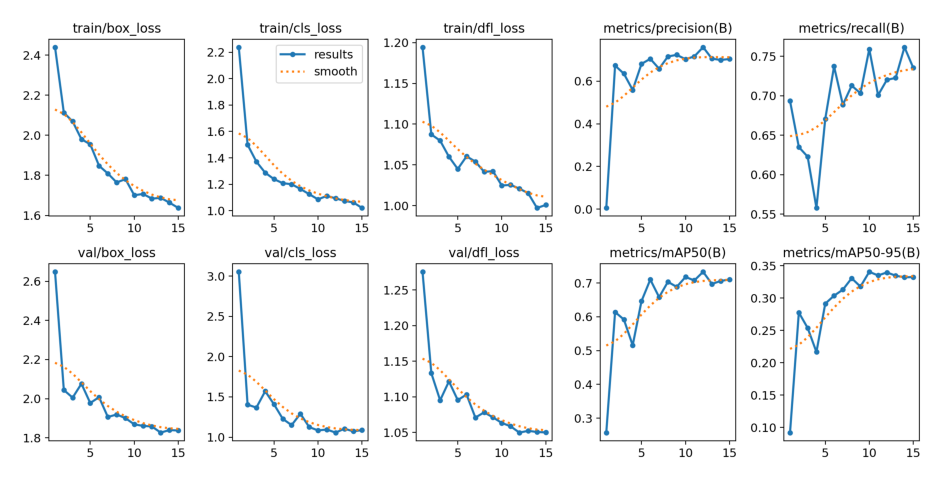

In [10]:
f, ax = plt.subplots(1, 1, figsize=(12,6))
ax.imshow(io.imread("runs/detect/train/results.png"))
plt.axis('off')

There's quite a number of plots here. Let's see what we have...

* The **box loss** describes the value of the loss function for localizing bounding boxes. The plot shows the box loss separately for the train and val datasets.
* The **cls loss** describes the value of the loss function for identifying the correct classes of the bounding boxes we found. There is a separate cls loss for the train and the val loss.
* The **dfl loss** is the distributed focal loss, which focuses on detecting difficult-to-find objects. Again, there is one for the train dataset and one for the val dataset.
* We also have the precision metric,
* the recall metric,
* the mean Average Precision 50 (mAP50) and 50-95 (mAP50-95) metrics.

All plots indicate a good learning progress. Let's perform an evaluation on the test dataset.

## Evaluation

To evaluate our model on the test dataset, we simply create a new dataset configuration file, but provide the test dataset as our validation dataset:

In [38]:
%%writefile dataset_test.yaml

# Train/val/test sets
path: /content/data # dataset root dir (note that this path is optimized for use in colab)
train: train # train images (relative to 'path')
val: test # this time we use the test dataset for evaluations (relative to 'path')

# define classes
names:
    0: car

Writing dataset_test.yaml


Now we simply rerun the validation step (but this time it will utilize the test dataset).

In [40]:
test_results = model.val(data="dataset_test.yaml")

Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/data/test.cache... 190 images, 31 backgrounds, 0 corrupt: 100%|██████████| 190/190 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.87it/s]


                   all        190        520      0.799      0.783      0.831      0.465
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train3


The results of the evaluation are written to files. Another way to access them is through the output of the `val` method. Let's have a look at the results.

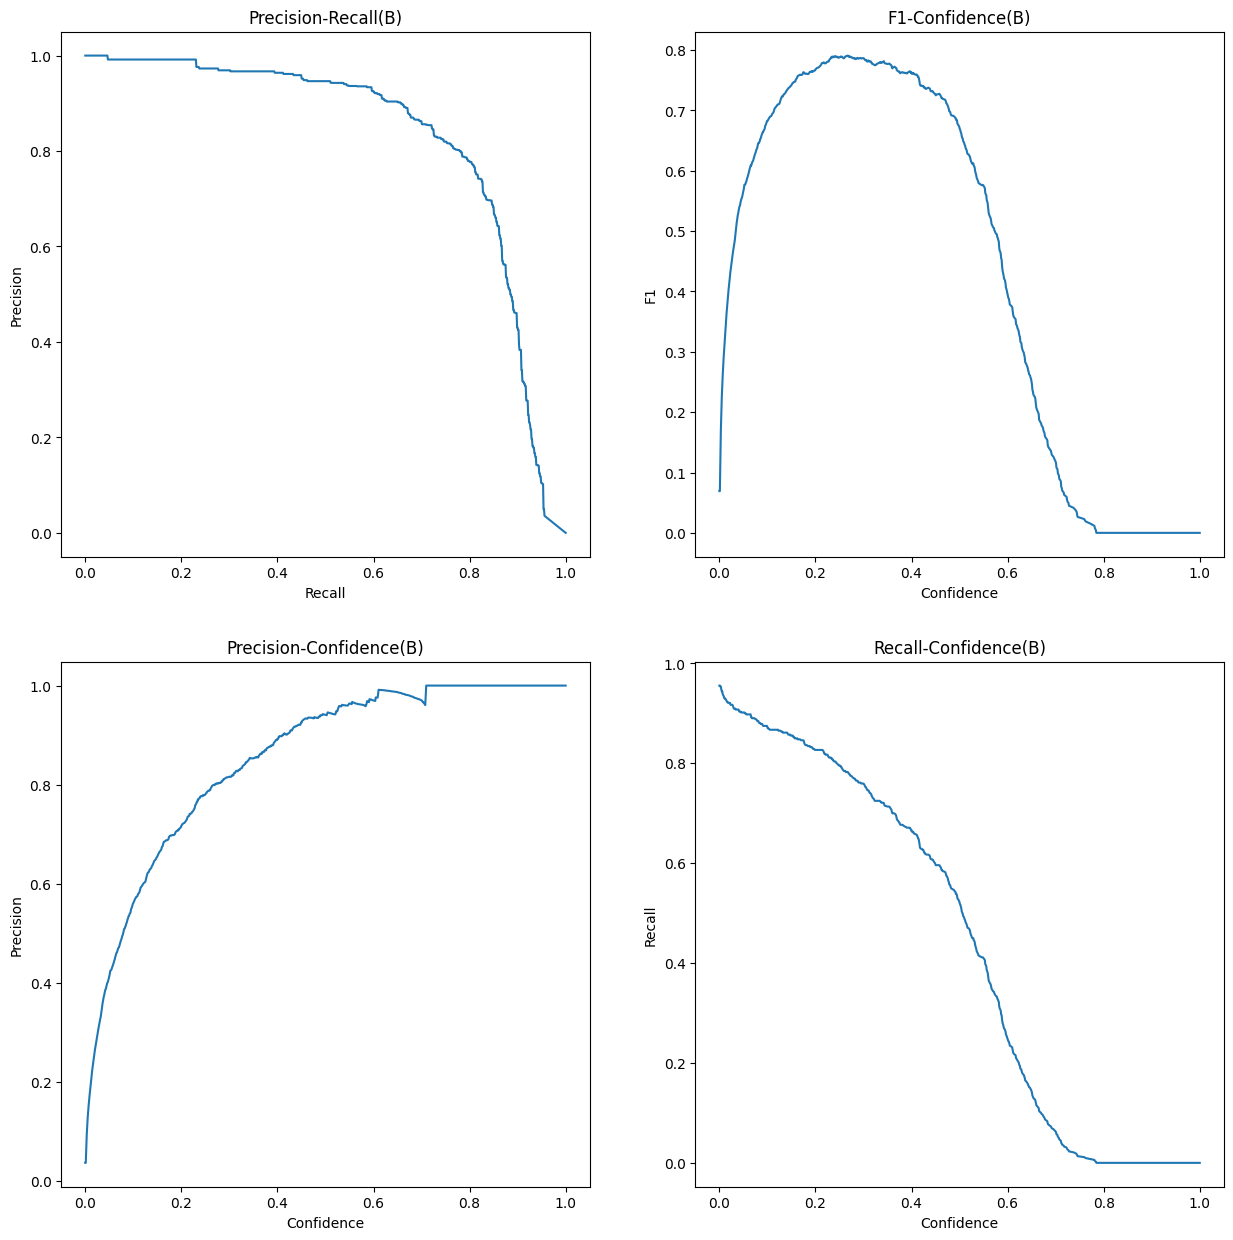

In [58]:
f, ax = plt.subplots(2, 2, figsize=(15,15))
ax = np.ravel(ax)

for i in range(len(test_results.curves)):
    ax[i].plot(test_results.curves_results[i][0], test_results.curves_results[i][1][0])
    ax[i].set_xlabel(test_results.curves_results[i][2])
    ax[i].set_ylabel(test_results.curves_results[i][3])
    ax[i].set_title(test_results.curves[i])

In [59]:
for metric, value in test_results.results_dict.items():
    print(metric, ':', value)

metrics/precision(B) : 0.7989017845988733
metrics/recall(B) : 0.7826923076923077
metrics/mAP50(B) : 0.8313585614102199
metrics/mAP50-95(B) : 0.46537224105328745
fitness : 0.5019708730889807


## Inference

Let's perform inference for one image from our training dataset. In the end, we simply provide a list of filenames to our model, which will return a `result` object for each sample. For a full discussion of the prediction step, please review the [predict guide](https://docs.ultralytics.com/modes/predict/).


0: 128x128 3 cars, 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 128, 128)


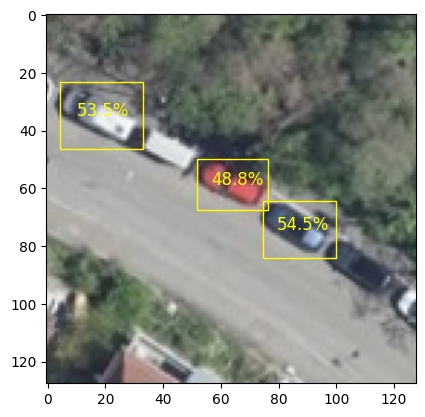

In [36]:
i = 2 # image index

# Perform inference on one image
results = model([train_filenames[i]],
                conf=0.4, # detection confidence threshold
                iou=0.6, # detection iou threshold)

# extract bounding boxes and confidences
bbs = results[0].boxes.xywh.cpu().numpy()
confs = results[0].boxes.conf.cpu().numpy()

# plot image
img = io.imread(train_filenames[i])
f, ax = plt.subplots(1, 1)
ax.imshow(img)

# add bounding boxes to plot
for i in range(bbs.shape[0]):
    # draw a rectangle for each bounding box; rectangle expects top left corner coordinates, width and heigth
    ax.add_patch(Rectangle(((bbs[i][0]-bbs[i][2]/2), (bbs[i][1]-bbs[i][3]/2)),
                           bbs[i][2], bbs[i][3], edgecolor='yellow', facecolor='none'))
    # add confidence values
    ax.annotate('{:.1f}%'.format(confs[i]*100), xy=(bbs[i][0]-bbs[i][2]*0.3, bbs[i][1]), fontsize=12, color='yellow')